In this notebook I'm going to experiment with different types of normalizations for the extracted MFCC coefficients. At this stage it is assumed that the source audio has been normalized already as necessary.<br/>
<br/>
As I have used LibROSA to load the audio dataset, it is asummed the most general audio normalizations had been done automatically: Bit Depth, Audio Channels, Sample Rate and also numeric values representing audio data for each individual file (not global).<br/>

<br/>
Normalization methods for MFCC coefficients we are going to experiment with:<br/>
<br/>

* **1. Per-channel Sepstral Mean Normalization**: Commonly used in Speech and Speaker Recognition to reduce varying channel effects occuring in the audio data. As the channel conditions are also different for each file, mean and standard deviation is computed individually for each audio sample. As a result, every audio sample is normalized individually.<br/>
<br/>

* **2. Global Sepstral Mean Normalization**: In this case the mean and standard deviation is computed over the entire dataset. In many project cases, the dataset may contain audio samples that are too short in length and do not provide reliable values for the mean and standard deviation.<br/>
<br/>

* **3. Mean Normalization**: some articles indicate that to balance the spectrum and improve the Signal-to-Noise (SNR) we can simply subtract the mean of each coefficient from all frames.<br/>
<br/>

<br/>
<br/>

In [1]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import random
from datetime import datetime 

from keras import backend as keras_backend, models
from keras.models import Sequential
from keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint 

from sklearn import metrics, preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# Set your path to the dataset
us8k_path = os.path.abspath('./UrbanSound8K')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')
models_path = os.path.abspath('./models')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

In [3]:
# Load the metadata from the generated CSV
metadata = pd.read_csv(metadata_path)

### Define some helper functions

In [4]:
# Randomize indexes
def randomize(total):
    indexes = list(range(0, total))
    
    # Randomize indexes
    random.shuffle(indexes)

    # Divide the indexes into Train and Test
    test_split_pct = 20
    split_offset = math.floor(test_split_pct * total / 100)

    # Split the metadata
    test_split_idx = indexes[0:split_offset]
    train_split_idx = indexes[split_offset:total]
    test_meta = metadata.iloc[test_split_idx]
    train_meta = metadata.iloc[train_split_idx]
    
    return [test_split_idx, train_split_idx, test_meta, train_meta]


# Split data
le = LabelEncoder()
def split(X, y, train_split, test_split, input_shape):
    # Split the features the with the same indexes
    X_test = np.take(X, test_split, axis=0)
    y_test = np.take(y, test_split, axis=0)
    X_train = np.take(X, train_split, axis=0)
    y_train = np.take(y, train_split, axis=0)
    
    # One-Hot
    y_test_encoded = to_categorical(le.fit_transform(y_test))
    y_train_encoded = to_categorical(le.fit_transform(y_train))

    # Reshape to fit the network input (channel last!)
    X_train = X_train.reshape(X_train.shape[0], input_shape[0], input_shape[1], input_shape[2])
    X_test = X_test.reshape(X_test.shape[0], input_shape[0], input_shape[1], input_shape[2])
    
    return [X_train, y_train_encoded, X_test, y_test_encoded]


# Create model
def create_model(input_shape, num_labels, learning_rate, X_test, y_test):
    model = Sequential()

    # General Spatial Dropout rate
    spatial_dropout_rate = 0.24

    # Conv 1
    model.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(spatial_dropout_rate))

    # Conv 2
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(spatial_dropout_rate))
    model.add(MaxPooling2D(pool_size=2))

    # Conv 3
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(spatial_dropout_rate))
    model.add(MaxPooling2D(pool_size=2))

    # Conv 4
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(spatial_dropout_rate))
    model.add(MaxPooling2D(pool_size=2))

    # Conv 5
    model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(spatial_dropout_rate))


    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())

    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    
    # Create optimizer
    adam = Adam(lr=learning_rate, beta_1=0.99, beta_2=0.999)
    model.compile(
        loss='categorical_crossentropy', 
        metrics=['accuracy'], 
        optimizer=adam)

    # Display model architecture summary 
    model.summary()

    # Calculate pre-training accuracy 
    score = model.evaluate(X_test, y_test, verbose=1)
    accuracy = 100 * score[1]

    print("Pre-training accuracy: %.4f%%" % accuracy) 

    return model



def train(model, X_train, y_train, X_test, y_test, num_epochs, num_batch_size, save_path):
    # Save checkpoints
    checkpointer = ModelCheckpoint(filepath=save_path, 
                                   verbose=1, 
                                   save_best_only=True)
    start = datetime.now()
    history = model.fit(X_train, 
                        y_train, 
                        batch_size=num_batch_size, 
                        epochs=num_epochs, 
                        validation_data=(X_test, y_test), 
                        callbacks=[checkpointer], 
                        verbose=1)

    duration = datetime.now() - start
    print("Training completed in time: ", duration)
    
    return history

### Pre-processed MFCC coefficients
We are using two versiones of the same exact data. In all cases, the data is pre-processed MFCC coefficients from the original UrbanSound8k dataset. MFCC extraction made with LibROSA.
<br/>
<br/>
**data-v1** is padded with zeros.<br/>
**data-v4** has beenpadded with np.nan, because we want to compute the mean only over the real data and not over the padding elements, so we will do our computations omitting np.nan values.<br/>
<br/>

In [5]:
# Pre-processed MFCC coefficients and labels & metadata
X_std = np.load("data/X-v1.npy")
y_std = np.load("data/y-v1.npy")

## Data normalization

#### 1. Per-channel Sepstral Mean Normalization


In [6]:
X_pcn = np.load("data/X-v4.npy")
y_pcn = np.load("data/y-v4.npy")

# Compute per-channel mean and std dev
mean = np.nanmean(X_pcn, axis=2, keepdims=True)
std = np.nanstd(X_pcn, axis=2, keepdims=True)

# Subtract mean on elements omitting NaN values
X_pcn = np.where(np.isnan(X_pcn), np.nan, X_pcn - mean)

# Divide by std dev. Note that std can be 0 only when all elements are the same, 
# but in this case the mean is equal to elements and after subtraction we obtain all zeros.
# The following like fixes this situation
X_pcn = np.where(X_pcn == 0, 0, X_pcn/std)


#### 2. Global Sepstral Mean Normalization

In [7]:
X_gcn = np.load("data/X-v4.npy")
y_gcn = np.load("data/y-v4.npy")

# Compute per-channel mean and std dev
global_mean = np.nanmean(X_gcn)
global_std = np.nanstd(X_gcn)

# Subtract mean on elements omitting NaN values
X_gcn[~np.isnan(X_gcn)] -= global_mean
X_gcn[~np.isnan(X_gcn)] /= global_std

# Convert all NaN to zero
X_gcn[np.isnan(X_gcn)] = 0.0

#### 3. Mean Normaliaztion
I'm curious about this normalization because -I think- substracting the mean without dividing by the standard deviation will only center the data around zero without scaling it.<br/>
But I have seen this method used quite a bit in the field of speech analysis/processing and I'd like to experiment with it.

In [8]:
X_mn = np.load("data/X-v4.npy")
y_mn = np.load("data/y-v4.npy")

X_means = np.nanmean(X_mn, axis=0) + 1e-8
X_mn = np.where(np.isnan(X_mn), np.nan, X_mn - X_means)

#### Data splits and shapes
Prepare the sample data splits (same train/test indexes for each test case)

In [9]:
total_samples = len(metadata)

# Returns: [test_split_idx, train_split_idx, test_meta, train_meta]
test_split_idx, train_split_idx, test_meta, train_meta = randomize(total_samples)

# Input / Output shapes
num_rows = 40
num_columns = 174
num_channels = 1
num_labels = 10
input_shape = (num_rows, num_columns, num_channels)

# Common training values
learning_rate = 1.5e-3
num_epochs = 60
num_batch_size = 256


## Tests

### Case 1: Per Channel Normalization

In [10]:
# Split data using general indexation
X_train_pcn, y_train_pcn, X_test_pcn, y_test_pcn = split(X_pcn, y_pcn, train_split_idx, test_split_idx, input_shape)

# Create instance of the common test model
model_pcn = create_model(input_shape, num_labels, learning_rate, X_test_pcn, y_test_pcn)

W0730 17:16:12.004546 139646614247232 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0730 17:16:12.021036 139646614247232 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 17:16:12.024863 139646614247232 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0730 17:16:12.050225 139646614247232 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_defaul

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 38, 172, 16)       160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 38, 172, 16)       64        
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 38, 172, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 170, 32)       4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 36, 170, 32)       128       
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 36, 170, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 85, 32)        0         
__________

In [11]:
# Saving settings
model_file = 'norm_test-pcn.hdf5'
pcn_save_path = os.path.join(models_path, model_file)

# Train the model with Per Channel Normalized data and get a history
history_pcn = train(model_pcn, X_train_pcn, y_train_pcn, X_test_pcn, y_test_pcn, num_epochs, num_batch_size, pcn_save_path)

W0730 17:16:17.118906 139646614247232 deprecation.py:323] From /home/eduugr/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6986 samples, validate on 1746 samples
Epoch 1/60
6986/6986 [==============================] - 51s 7ms/step - loss: 2.0628 - acc: 0.2786 - val_loss: 2.0685 - val_acc: 0.3935

Epoch 00001: val_loss improved from inf to 2.06848, saving model to /mnt/disks/disk-1/projects/urban-audio-classifier/models/norm_test-pcn.hdf5
Epoch 2/60
6986/6986 [==============================] - 46s 7ms/step - loss: 1.6376 - acc: 0.3991 - val_loss: 2.5192 - val_acc: 0.3282

Epoch 00002: val_loss did not improve from 2.06848
Epoch 3/60
6986/6986 [==============================] - 46s 7ms/step - loss: 1.5217 - acc: 0.4397 - val_loss: 2.4927 - val_acc: 0.3591

Epoch 00003: val_loss did not improve from 2.06848
Epoch 4/60
6986/6986 [==============================] - 47s 7ms/step - loss: 1.4253 - acc: 0.4917 - val_loss: 2.2434 - val_acc: 0.4118

Epoch 00004: val_loss did not improve from 2.06848
Epoch 5/60
6986/6986 [==============================] - 48s 7ms/step - loss: 1.3632 - acc: 0.5099 - val_loss: 2


Epoch 00033: val_loss did not improve from 0.68991
Epoch 34/60
6986/6986 [==============================] - 47s 7ms/step - loss: 0.7114 - acc: 0.7476 - val_loss: 0.6808 - val_acc: 0.7726

Epoch 00034: val_loss improved from 0.68991 to 0.68075, saving model to /mnt/disks/disk-1/projects/urban-audio-classifier/models/norm_test-pcn.hdf5
Epoch 35/60
6986/6986 [==============================] - 47s 7ms/step - loss: 0.6935 - acc: 0.7552 - val_loss: 0.6625 - val_acc: 0.7658

Epoch 00035: val_loss improved from 0.68075 to 0.66252, saving model to /mnt/disks/disk-1/projects/urban-audio-classifier/models/norm_test-pcn.hdf5
Epoch 36/60
6986/6986 [==============================] - 47s 7ms/step - loss: 0.6780 - acc: 0.7575 - val_loss: 0.6510 - val_acc: 0.7749

Epoch 00036: val_loss improved from 0.66252 to 0.65100, saving model to /mnt/disks/disk-1/projects/urban-audio-classifier/models/norm_test-pcn.hdf5
Epoch 37/60
6986/6986 [==============================] - 47s 7ms/step - loss: 0.6711 - acc: 0

### Case 1: model evaluation

In [12]:
# Load the best saved model
model = models.load_model(pcn_save_path)

In [13]:
# Score on training data
score = model.evaluate(X_train_pcn, y_train_pcn, verbose=0)
print("Training Accuracy: ", score[1])

# Score on test data
score = model.evaluate(X_test_pcn, y_test_pcn, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9461780704265674
Testing Accuracy:  0.8012600230460587


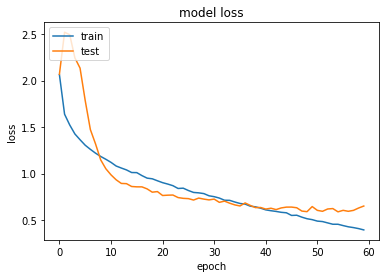

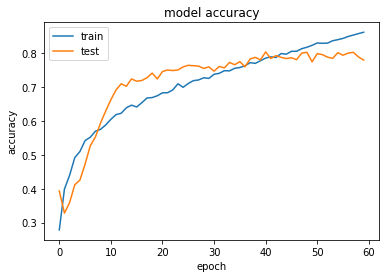

In [14]:
# summarize history for loss
plt.plot(history_pcn.history['loss'])
plt.plot(history_pcn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history_pcn.history['acc'])
plt.plot(history_pcn.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Case 2: Global Mean Normalization

In [15]:
# Split data using general indexation
X_train_gcn, y_train_gcn, X_test_gcn, y_test_gcn = split(X_gcn, y_gcn, train_split_idx, test_split_idx, input_shape)

# Create instance of the common test model
model_gcn = create_model(input_shape, num_labels, learning_rate, X_test_gcn, y_test_gcn)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 38, 172, 16)       160       
_________________________________________________________________
batch_normalization_6 (Batch (None, 38, 172, 16)       64        
_________________________________________________________________
spatial_dropout2d_6 (Spatial (None, 38, 172, 16)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 36, 170, 32)       4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 36, 170, 32)       128       
_________________________________________________________________
spatial_dropout2d_7 (Spatial (None, 36, 170, 32)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 85, 32)        0         
__________

In [16]:
# Saving settings
model_file = 'norm_test-gcn.hdf5'
gcn_save_path = os.path.join(models_path, model_file)

# Train the model with Per Channel Normalized data and get a history
history_gcn = train(model_gcn, X_train_gcn, y_train_gcn, X_test_gcn, y_test_gcn, num_epochs, num_batch_size, gcn_save_path)

Train on 6986 samples, validate on 1746 samples
Epoch 1/60
6986/6986 [==============================] - 50s 7ms/step - loss: 2.1685 - acc: 0.2592 - val_loss: 1.8004 - val_acc: 0.3706

Epoch 00001: val_loss improved from inf to 1.80038, saving model to /mnt/disks/disk-1/projects/urban-audio-classifier/models/norm_test-gcn.hdf5
Epoch 2/60
6986/6986 [==============================] - 46s 7ms/step - loss: 1.6863 - acc: 0.3863 - val_loss: 2.1115 - val_acc: 0.4021

Epoch 00002: val_loss did not improve from 1.80038
Epoch 3/60
6986/6986 [==============================] - 46s 7ms/step - loss: 1.5499 - acc: 0.4395 - val_loss: 2.5373 - val_acc: 0.3654

Epoch 00003: val_loss did not improve from 1.80038
Epoch 4/60
6986/6986 [==============================] - 46s 7ms/step - loss: 1.4581 - acc: 0.4815 - val_loss: 2.3000 - val_acc: 0.3958

Epoch 00004: val_loss did not improve from 1.80038
Epoch 5/60
6986/6986 [==============================] - 47s 7ms/step - loss: 1.3990 - acc: 0.5016 - val_loss: 2


Epoch 00032: val_loss did not improve from 0.69978
Epoch 33/60
6986/6986 [==============================] - 48s 7ms/step - loss: 0.7059 - acc: 0.7512 - val_loss: 0.6995 - val_acc: 0.7675

Epoch 00033: val_loss improved from 0.69978 to 0.69948, saving model to /mnt/disks/disk-1/projects/urban-audio-classifier/models/norm_test-gcn.hdf5
Epoch 34/60
6986/6986 [==============================] - 48s 7ms/step - loss: 0.6958 - acc: 0.7541 - val_loss: 0.6720 - val_acc: 0.7709

Epoch 00034: val_loss improved from 0.69948 to 0.67197, saving model to /mnt/disks/disk-1/projects/urban-audio-classifier/models/norm_test-gcn.hdf5
Epoch 35/60
6986/6986 [==============================] - 49s 7ms/step - loss: 0.6905 - acc: 0.7614 - val_loss: 0.6945 - val_acc: 0.7560

Epoch 00035: val_loss did not improve from 0.67197
Epoch 36/60
6986/6986 [==============================] - 48s 7ms/step - loss: 0.6591 - acc: 0.7654 - val_loss: 0.6797 - val_acc: 0.7801

Epoch 00036: val_loss did not improve from 0.67197
Ep

### Case 2: model evaluation

In [17]:
# Load the best saved model
model = models.load_model(gcn_save_path)

In [18]:
# Score on training data
score = model.evaluate(X_train_gcn, y_train_gcn, verbose=0)
print("Training Accuracy: ", score[1])

# Score on test data
score = model.evaluate(X_test_gcn, y_test_gcn, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.936873747512054
Testing Accuracy:  0.7943871707441061


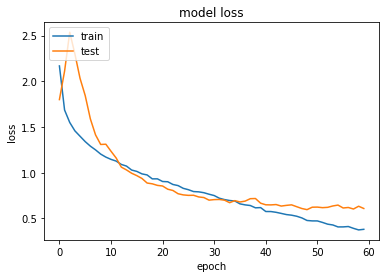

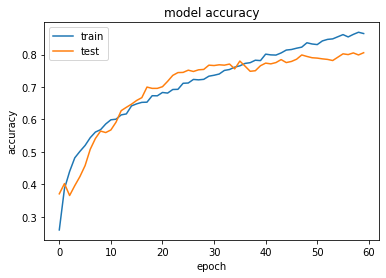

In [19]:
# summarize history for loss
plt.plot(history_gcn.history['loss'])
plt.plot(history_gcn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history_gcn.history['acc'])
plt.plot(history_gcn.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Case 3: Mean Normaliaztion

In [20]:
# Split data using general indexation
X_train_mn, y_train_mn, X_test_mn, y_test_mn = split(X_mn, y_mn, train_split_idx, test_split_idx, input_shape)

# Create instance of the common test model
model_mn = create_model(input_shape, num_labels, learning_rate, X_test_mn, y_test_mn)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 38, 172, 16)       160       
_________________________________________________________________
batch_normalization_11 (Batc (None, 38, 172, 16)       64        
_________________________________________________________________
spatial_dropout2d_11 (Spatia (None, 38, 172, 16)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 36, 170, 32)       4640      
_________________________________________________________________
batch_normalization_12 (Batc (None, 36, 170, 32)       128       
_________________________________________________________________
spatial_dropout2d_12 (Spatia (None, 36, 170, 32)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 85, 32)        0         
__________

In [21]:
# Saving settings
model_file = 'norm_test-mn.hdf5'
mn_save_path = os.path.join(models_path, model_file)

# Train the model with Per Channel Normalized data and get a history
history_mn = train(model_mn, X_train_mn, y_train_mn, X_test_mn, y_test_mn, num_epochs, num_batch_size, mn_save_path)

Train on 6986 samples, validate on 1746 samples
Epoch 1/60
6986/6986 [==============================] - 50s 7ms/step - loss: 2.1757 - acc: 0.2602 - val_loss: 1.9081 - val_acc: 0.3517

Epoch 00001: val_loss improved from inf to 1.90811, saving model to /mnt/disks/disk-1/projects/urban-audio-classifier/models/norm_test-mn.hdf5
Epoch 2/60
6986/6986 [==============================] - 46s 7ms/step - loss: 1.6883 - acc: 0.3828 - val_loss: 2.2819 - val_acc: 0.3832

Epoch 00002: val_loss did not improve from 1.90811
Epoch 3/60
6986/6986 [==============================] - 46s 7ms/step - loss: 1.5525 - acc: 0.4313 - val_loss: 2.0079 - val_acc: 0.3975

Epoch 00003: val_loss did not improve from 1.90811
Epoch 4/60
6986/6986 [==============================] - 46s 7ms/step - loss: 1.4782 - acc: 0.4505 - val_loss: 2.0576 - val_acc: 0.4118

Epoch 00004: val_loss did not improve from 1.90811
Epoch 5/60
6986/6986 [==============================] - 46s 7ms/step - loss: 1.4043 - acc: 0.4884 - val_loss: 2.


Epoch 00032: val_loss improved from 0.71570 to 0.70340, saving model to /mnt/disks/disk-1/projects/urban-audio-classifier/models/norm_test-mn.hdf5
Epoch 33/60
6986/6986 [==============================] - 46s 7ms/step - loss: 0.7413 - acc: 0.7418 - val_loss: 0.7071 - val_acc: 0.7583

Epoch 00033: val_loss did not improve from 0.70340
Epoch 34/60
6986/6986 [==============================] - 46s 7ms/step - loss: 0.7205 - acc: 0.7481 - val_loss: 0.7049 - val_acc: 0.7600

Epoch 00034: val_loss did not improve from 0.70340
Epoch 35/60
6986/6986 [==============================] - 46s 7ms/step - loss: 0.6965 - acc: 0.7614 - val_loss: 0.7062 - val_acc: 0.7537

Epoch 00035: val_loss did not improve from 0.70340
Epoch 36/60
6986/6986 [==============================] - 46s 7ms/step - loss: 0.6998 - acc: 0.7555 - val_loss: 0.6953 - val_acc: 0.7680

Epoch 00036: val_loss improved from 0.70340 to 0.69525, saving model to /mnt/disks/disk-1/projects/urban-audio-classifier/models/norm_test-mn.hdf5
Epoc

### Case 3: model evaluation

In [22]:
# Load the best saved model
model = models.load_model(mn_save_path)

In [23]:
# Score on training data
score = model.evaluate(X_train_mn, y_train_mn, verbose=0)
print("Training Accuracy: ", score[1])

# Score on test data
score = model.evaluate(X_test_mn, y_test_mn, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9453192098141399
Testing Accuracy:  0.7972508592430805


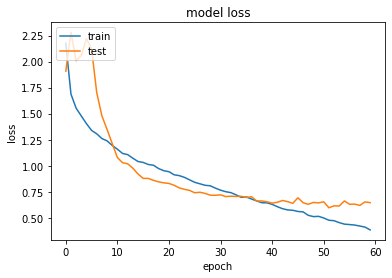

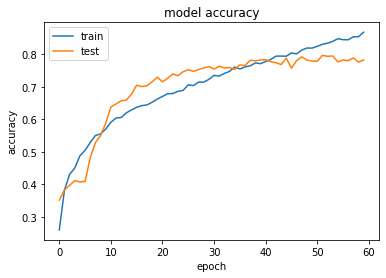

In [24]:
# summarize history for loss
plt.plot(history_mn.history['loss'])
plt.plot(history_mn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history_mn.history['acc'])
plt.plot(history_mn.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()